# Fashion MNIST Dataset: Custom vs PyTorch Neural Network

This notebook trains identical models on the Fashion MNIST dataset.

First, I train a homemade neural network using the /cnn module I built. Then train a neural network of identical strcuture using PyTorch as a comparison.

In [1]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from keras.datasets import fashion_mnist
sns.set_theme()

In [2]:
from cnn import Sequential 
from cnn.layers import Linear, ReLU, Softmax, Flatten, Conv2d, MaxPool2d, Dropout
from cnn.loss import CrossEntropyLoss
from cnn.optim import Adam
from cnn.utils import generate_spiral_data, plot_spiral_data_decision_boundary, train_val_test_split, train_val, plot_training_metrics, test

### 1. Load and Visualize Data

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

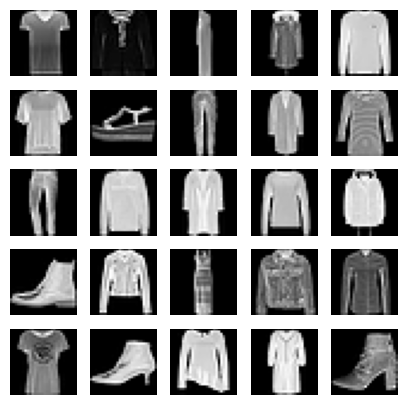

In [4]:
r = 5 
indexes = np.random.randint(0, x_train.shape[0], size=r ** 2)
images = x_train[indexes]
labels = y_train[indexes]

plt.figure(figsize=(r,r))
for i in range(len(indexes)):
    plt.subplot(r, r, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.close('all')

### 2. Build, Train, and Test Homemade Model

In [5]:
X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
X = X / 255.0 

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

In [6]:
X_train = np.expand_dims(X_train,axis=1)
X_val = np.expand_dims(X_val,axis=1)
X_test = np.expand_dims(X_test,axis=1)

In [7]:
ordered_layers = [
  Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
  ReLU(),
  MaxPool2d(kernel_size = 2, stride = 2),
  
  Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
  ReLU(),
  MaxPool2d(kernel_size = 2, stride = 2),

  Flatten(),

  Linear(1568, 128),
  ReLU(),
  Dropout(),
  
  Linear(128, 10),
  Softmax()
]

loss = CrossEntropyLoss()
optim = Adam()
model = Sequential(
  layers=ordered_layers,
  loss_func = loss,
  optimizer = optim
)

EPOCHS = 10
batch_size = 32

train_losses, train_accuracies, val_losses, val_accuracies = train_val(
  model, 
  X_train, 
  y_train, 
  X_val, 
  y_val, 
  epochs=EPOCHS, 
  batch_size = batch_size,
  verbose_freq = 1
)

Epoch 1, Train Loss: 0.649502, Train Accuracy: 0.756327, Val Loss: 0.495400, Val Accuracy: 0.819810
Epoch 2, Train Loss: 0.451505, Train Accuracy: 0.834796, Val Loss: 0.428013, Val Accuracy: 0.846286
Epoch 3, Train Loss: 0.405575, Train Accuracy: 0.852612, Val Loss: 0.390280, Val Accuracy: 0.862667
Epoch 4, Train Loss: 0.371916, Train Accuracy: 0.865041, Val Loss: 0.376149, Val Accuracy: 0.865333
Epoch 5, Train Loss: 0.347386, Train Accuracy: 0.874265, Val Loss: 0.352605, Val Accuracy: 0.873048
Epoch 6, Train Loss: 0.330438, Train Accuracy: 0.880551, Val Loss: 0.333067, Val Accuracy: 0.877143
Epoch 7, Train Loss: 0.311599, Train Accuracy: 0.885286, Val Loss: 0.341394, Val Accuracy: 0.876762
Epoch 8, Train Loss: 0.302542, Train Accuracy: 0.888020, Val Loss: 0.335244, Val Accuracy: 0.881524
Epoch 9, Train Loss: 0.294811, Train Accuracy: 0.891224, Val Loss: 0.321411, Val Accuracy: 0.886286
Epoch 10, Train Loss: 0.287114, Train Accuracy: 0.895469, Val Loss: 0.307606, Val Accuracy: 0.892381

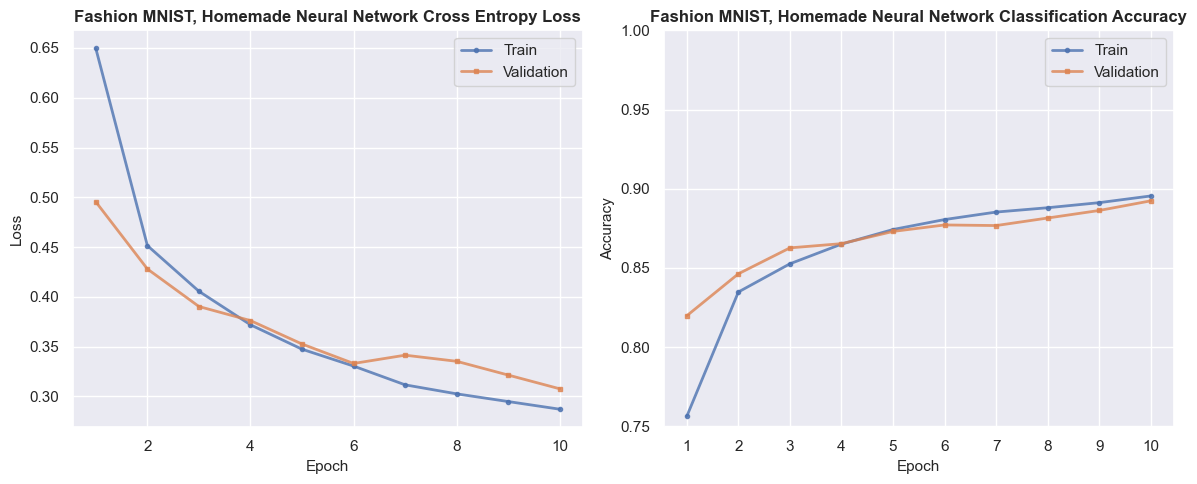

Test Loss: 0.310326, Test Accuracy: 0.892571


In [8]:
xticks = list(range(2, len(train_losses) + 1, 2))
plot_training_metrics(
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
    title="Fashion MNIST, Homemade Neural Network",
    #xticks = xticks
)
test_loss, test_accuracy = test(model, X_test, y_test)

### 3. Build, Train, and Test PyTorch Model for Comparison

In [9]:
import torch.nn.functional as F
import torch.nn as nn 
import torch.optim as optim 
from sklearn.model_selection import train_test_split
from pytorch_utils import pytorch_generate_dataloader, pytorch_train_val, pytorch_test, pytorch_plot_spiral_data_decision_boundary

In [10]:
dataloader_train = pytorch_generate_dataloader(X_train, y_train, batch_size)
dataloader_val = pytorch_generate_dataloader(X_val, y_val, batch_size)
dataloader_test = pytorch_generate_dataloader(X_test, y_test, batch_size)


In [11]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(1568, 128)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(128, num_classes)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x
    

In [12]:
model = CNN(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss() 

train_losses, train_accuracies, val_losses, val_accuracies = pytorch_train_val(
  model,
  dataloader_train,
  dataloader_val,
  criterion,
  optimizer,
  epochs=EPOCHS,
  verbose_freq = 1
)

Epoch 1, Train Loss: 0.651240, Train Accuracy: 0.760510, Val Loss: 0.385110, Val Accuracy: 0.858857
Epoch 2, Train Loss: 0.433265, Train Accuracy: 0.843184, Val Loss: 0.330013, Val Accuracy: 0.879619
Epoch 3, Train Loss: 0.384558, Train Accuracy: 0.864224, Val Loss: 0.297894, Val Accuracy: 0.893143
Epoch 4, Train Loss: 0.348982, Train Accuracy: 0.874959, Val Loss: 0.283114, Val Accuracy: 0.893524
Epoch 5, Train Loss: 0.320383, Train Accuracy: 0.883143, Val Loss: 0.268659, Val Accuracy: 0.903143
Epoch 6, Train Loss: 0.300816, Train Accuracy: 0.892000, Val Loss: 0.261307, Val Accuracy: 0.908762
Epoch 7, Train Loss: 0.282501, Train Accuracy: 0.896939, Val Loss: 0.251008, Val Accuracy: 0.909143
Epoch 8, Train Loss: 0.268608, Train Accuracy: 0.901816, Val Loss: 0.260627, Val Accuracy: 0.907143
Epoch 9, Train Loss: 0.256470, Train Accuracy: 0.904245, Val Loss: 0.242025, Val Accuracy: 0.912095
Epoch 10, Train Loss: 0.242771, Train Accuracy: 0.911000, Val Loss: 0.240130, Val Accuracy: 0.913048

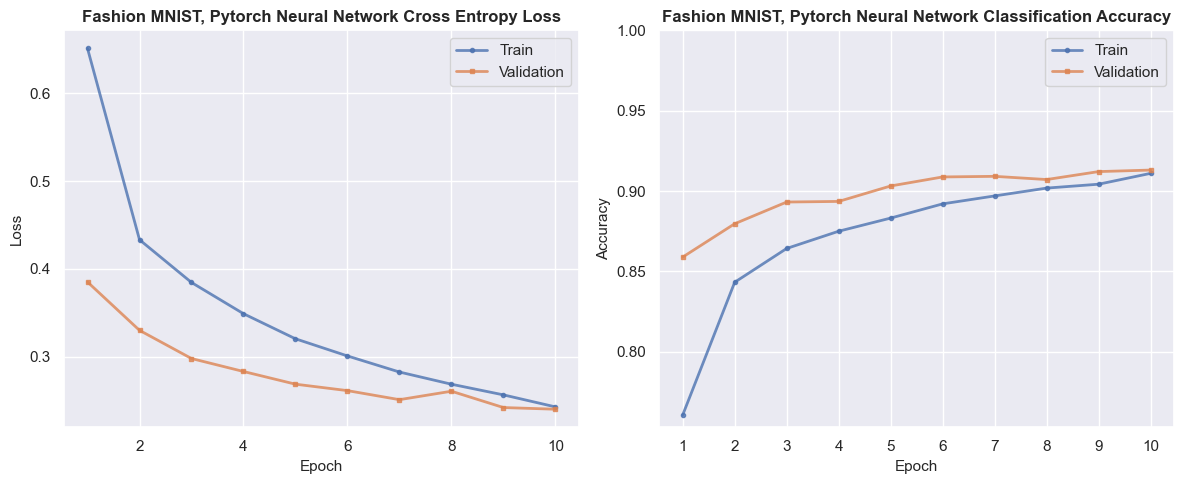

Test Loss: 0.228910, Test Accuracy: 0.915810


In [13]:
xticks = list(range(2, len(train_losses) + 1, 2))
plot_training_metrics(
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
    title="Fashion MNIST, Pytorch Neural Network",
    #xticks = xticks
)

test_loss, test_accuracy = pytorch_test(model, dataloader_test, criterion)